In [1]:
!pip3 install category_encoders torch nbformat


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import os

import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
from math import sqrt

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder, TargetEncoder
from scipy.sparse import hstack

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv("../resources/HI-Small_Trans.csv")
print(df.columns);
print(df.shape)
df.head()

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')
(5078345, 11)


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [5]:
df[-5:]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0
5078344,2022/09/10 23:37,154518,8148A6091,256398,8148A8711,0.281983,Bitcoin,0.281983,Bitcoin,Bitcoin,0


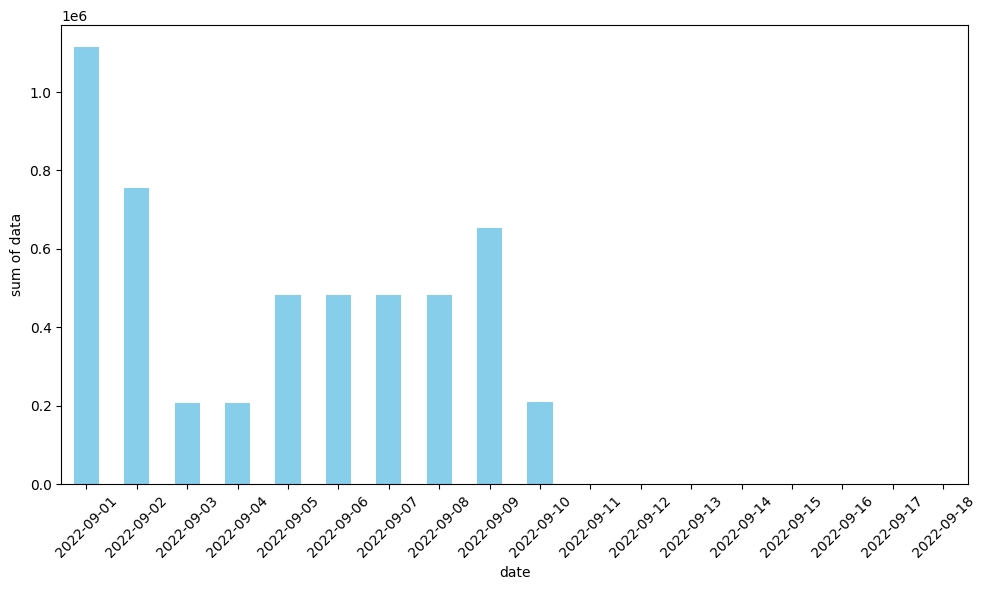

In [6]:
# 查看日期粒度下的数据分布情况
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Date'] = df['Timestamp'].dt.date
df.set_index('Date', inplace=True)

daily_data_count = df.groupby(df.index).size()

plt.figure(figsize=(10, 6))
daily_data_count.plot(kind='bar', color='skyblue')
plt.xlabel('date')
plt.ylabel('sum of data')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

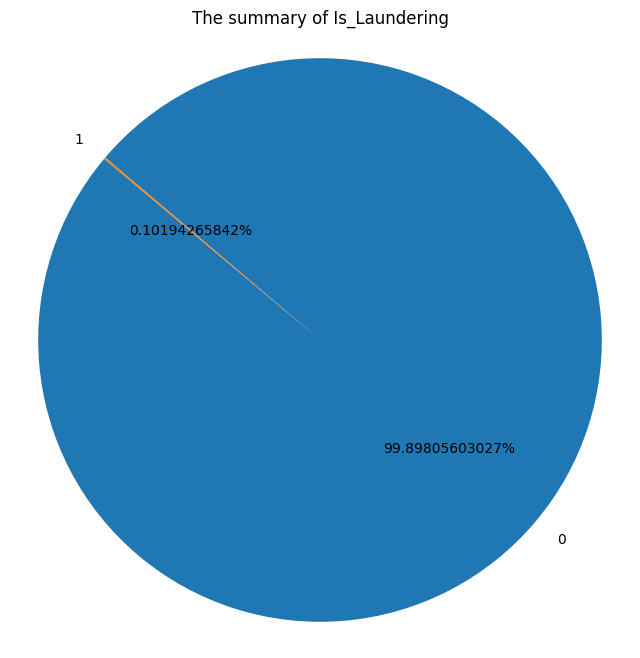

In [7]:
# 统计 "Is_Laundering" 列的分布情况
laundering_counts = df['Is_Laundering'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.11f%%', startangle=140)
plt.title('The summary of Is_Laundering')
plt.axis('equal')  # 保持饼图的纵横比一致

plt.show()

可以看到，labels的分布是不平衡的。

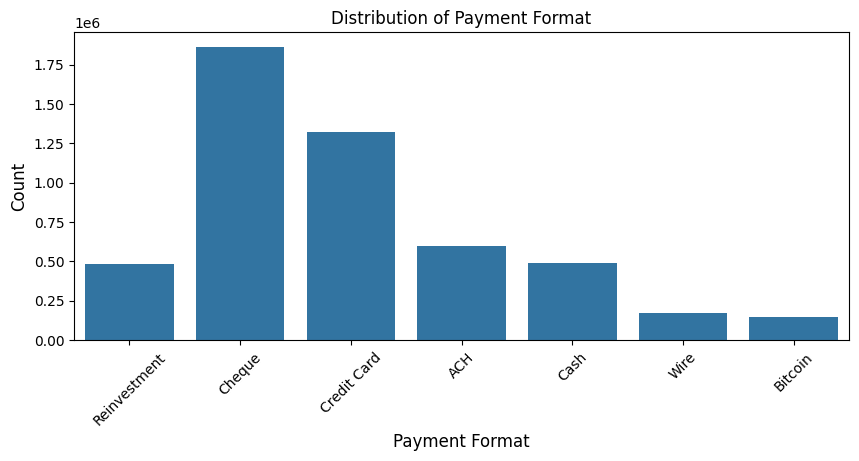

In [8]:
# 查看Payment Format的分布情况
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Set the x-axis tick labels to the original values
# ax.set_xticklabels(df['Payment Format'].unique())

plt.show()

In [9]:
df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire',
       'Bitcoin'], dtype=object)

这几种支付方式的复杂程度由小到大为：

现金(Cash)
现金无需任何系统或设备,直接完成支付,是最简单的方式。

支票(Cheque)
支票只需要纸质支票和银行账户,虽简单但需要等待结算。

自动清算所(ACH)
ACH需要建立起银行间转账系统,步骤多但日常使用简单。

信用卡(Credit Card)
信用卡看似简单,但需要处理发卡机构结算等复杂系统。

电汇(Wire)
电汇看似直接转账,但涉及国际复杂监管和结算流程。

比特币(Bitcoin)
比特币概念抽象,需要处理秘钥、交易等诸多新概念。

再投资(Reinvestment)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5078345 entries, 2022-09-01 to 2022-09-10
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is_Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 497.2+ MB


可以看到有些属性的类型是object，所以待会需要将其量化。

In [11]:
# 删除重复数据
print(df.shape)
df = df.drop_duplicates(keep = 'first')
df.shape

(5078345, 11)


(5078336, 11)

In [12]:
# 是否有NA
has_nan = df.isnull().values.any()

if has_nan:
    print("NaN")
    print(df.isnull().sum())
else:
    print("not NaN")

not NaN


In [13]:
#数据的基本信息
df.describe()

,Timestamp,From Bank,To Bank,Amount Received,Amount Paid,Is_Laundering
count,5078336,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06
mean,2022-09-05 07:16:07.855403520,4.573058e+04,6.574461e+04,5.988737e+06,4.509281e+06,1.019428e-03
min,2022-09-01 00:00:00,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,2022-09-02 04:32:00,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,2022-09-05 12:16:00,9.679000e+03,2.156800e+04,1.411040e+03,1.414570e+03,0.000000e+00
75%,2022-09-08 03:13:00,2.862800e+04,1.223320e+05,1.234630e+04,1.229815e+04,0.000000e+00
max,2022-09-18 16:18:00,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00
std,NaN,8.176567e+04,8.409303e+04,1.037184e+09,8.697736e+08,3.191221e-02


In [14]:
# 选择object类型的列
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

**对非整型和浮点型的数据进行量化:**

In [15]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2022-09-01,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [16]:
# 查看各属性中的不同的value分别有多少
for col in object_cols:
    print(col,'\n')
    print(df[col].nunique(), '\n')
    print(df[col].value_counts())

Account 

496995 

Account
100428660    168672
1004286A8    103018
100428978     20497
1004286F0     18663
100428780     17264
              ...  
806198930         1
806197550         1
80127BE50         1
8061935F0         1
8148A8671         1
Name: count, Length: 496995, dtype: int64
Account.1 

420636 

Account.1
100428660    1084
1004286A8     653
80F47A310     159
100428978     150
8018859B0     144
             ... 
80B14E9D0       1
80B159D00       1
812577710       1
812569750       1
80F91C540       1
Name: count, Length: 420636, dtype: int64
Receiving Currency 

15 

Receiving Currency
US Dollar            1879341
Euro                 1172017
Swiss Franc           237884
Yuan                  206551
Shekel                194988
Rupee                 192065
UK Pound              181255
Ruble                 157361
Yen                   156319
Bitcoin               148142
Canadian Dollar       141357
Australian Dollar     138511
Mexican Peso          111030
Saudi Riyal       

In [17]:
# 选择object类型的列
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)

# 使用Label Encoding对object类型的列进行量化
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# 根据支付的复杂程度排序
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

# 输出处理后的数据
df.head()

['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,942,10,900,3697.34,12,3697.34,12,7,0
2022-09-01,2022-09-01 00:20:00,3208,990,1,949,0.01,12,0.01,12,2,0
2022-09-01,2022-09-01 00:00:00,3209,991,3209,940,14675.57,12,14675.57,12,7,0
2022-09-01,2022-09-01 00:02:00,12,997,12,945,2806.97,12,2806.97,12,7,0
2022-09-01,2022-09-01 00:06:00,10,999,10,947,36682.97,12,36682.97,12,7,0


**归一化：**

In [18]:
# 全部属性归一化

# 将标签从数据集中分离出来
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)

# 将Timestamp列转换为时间戳
'''
    这行代码将`df`数据框中的`Timestamp`列转换为Unix时间戳。
    具体来说，它将`Timestamp`列中的日期时间值转换为Unix时间戳，然后将其除以10的9次方，以将时间戳转换为秒数。
    更具体地说，`pd.to_datetime(df['Timestamp'])`将`Timestamp`列中的日期时间值转换为Pandas的`Timestamp`对象。
    然后，`.astype(int)`将`Timestamp`对象转换为整数，表示自1970年1月1日以来的纳秒数。
    最后，`/ 10**9`将纳秒数除以10的9次方，以将时间戳转换为秒数。
'''
df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9

# 对数据集进行归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# 将归一化后的数据转换为DataFrame对象，并设置列名
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)

# 将标签列添加回归一化后的数据集
df_normalized['Is_Laundering'] = labels.tolist()

# 输出归一化后的数据
print(df_normalized.head())

   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.998429  -0.999949 -0.996209 -0.999949  -0.995721             -1.0   
1  -0.998429  -0.981998 -0.996016 -1.000000  -0.995488             -1.0   
2  -1.000000  -0.981993 -0.996012 -0.981992  -0.995531             -1.0   
3  -0.999843  -0.999938 -0.995988 -0.999938  -0.995507             -1.0   
4  -0.999529  -0.999949 -0.995980 -0.999949  -0.995497             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [19]:
# 选择Is_Laundering列为1的行
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# 输出选择后的数据
print(df_normalized.count())
df_laundering.count()

Timestamp             5078336
From Bank             5078336
Account               5078336
To Bank               5078336
Account.1             5078336
Amount Received       5078336
Receiving Currency    5078336
Amount Paid           5078336
Payment Currency      5078336
Payment Format        5078336
Is_Laundering         5078336
dtype: int64


Timestamp             5177
From Bank             5177
Account               5177
To Bank               5177
Account.1             5177
Amount Received       5177
Receiving Currency    5177
Amount Paid           5177
Payment Currency      5177
Payment Format        5177
Is_Laundering         5177
dtype: int64

/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/3707874914.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, color='b')


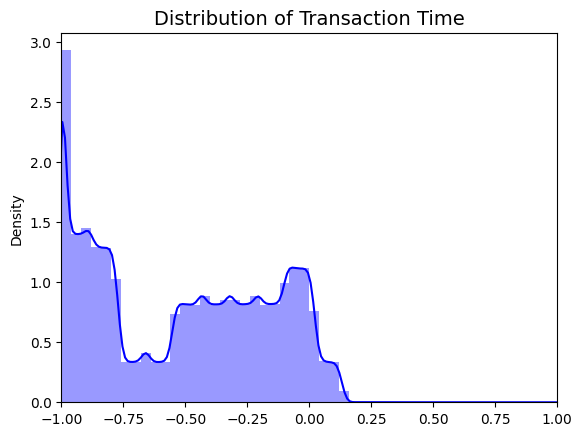

In [20]:
time_val = df_normalized['Timestamp'].values
sns.distplot(time_val, color='b')
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim([min(time_val), max(time_val)])

plt.show()

**接下来拆分数据集为训练集和测试集：（仅仅作为观察用，后面不会用到）**

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold

X = df_normalized.drop('Is_Laundering', axis=1)
y = df_normalized['Is_Laundering']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
    # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the Distribution of the labels


    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

Train: [1015216 1015217 1015218 ... 5078333 5078334 5078335] Test: [      0       1       2 ... 1640857 1643788 1644721]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898072 0.00101928]
[0.99897998 0.00102002]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [1015216 1015217 1015218 ... 2284009 2284931 2285027]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [2030816 2030817 2030818 ... 3208454 3208819 3214577]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [3046760 3046761 3046762 ... 4296460 4297262 4298091]


可以看到，数据被拆分为了训练集和测试集，且分布均衡。

**接下来采用欠采样的方法准备数据：**

In [22]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df_normalized = df_normalized.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
3910925,-0.169220,-0.242356,0.315746,-0.999360,0.303448,-1.0,-0.714286,-1.0,-0.714286,-0.333333,0
4485312,-0.048001,-0.796948,-0.580760,-0.960476,-0.591470,-1.0,0.714286,-1.0,0.714286,-0.666667,0
1746595,-0.507267,-0.353593,-0.058303,-0.983435,-0.843546,-1.0,0.714286,-1.0,0.714286,-0.333333,1
1948601,-0.597298,-0.856678,-0.068274,-0.923922,-0.460801,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
4913079,0.033938,0.429091,0.934406,-0.137199,0.930843,-1.0,-0.857143,-1.0,-0.857143,0.666667,1


Distribution of the Is_Launderinges in the subsample dataset
Is_Laundering
0    0.5
1    0.5
Name: count, dtype: float64


/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/2184186143.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='Is_Laundering', palette=colors)


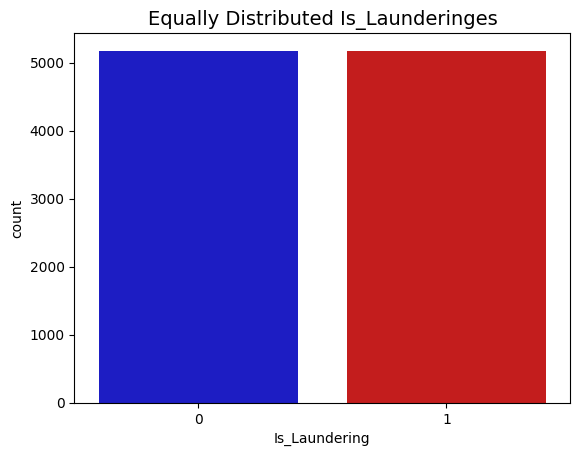

In [23]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is_Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is_Laundering', palette=colors)
plt.title('Equally Distributed Is_Launderinges', fontsize=14)
plt.show()

欠采样的方法：将多余的label为0的数据全部阶段，只保留和label为1数量一样多的数据。

**相关系数：**

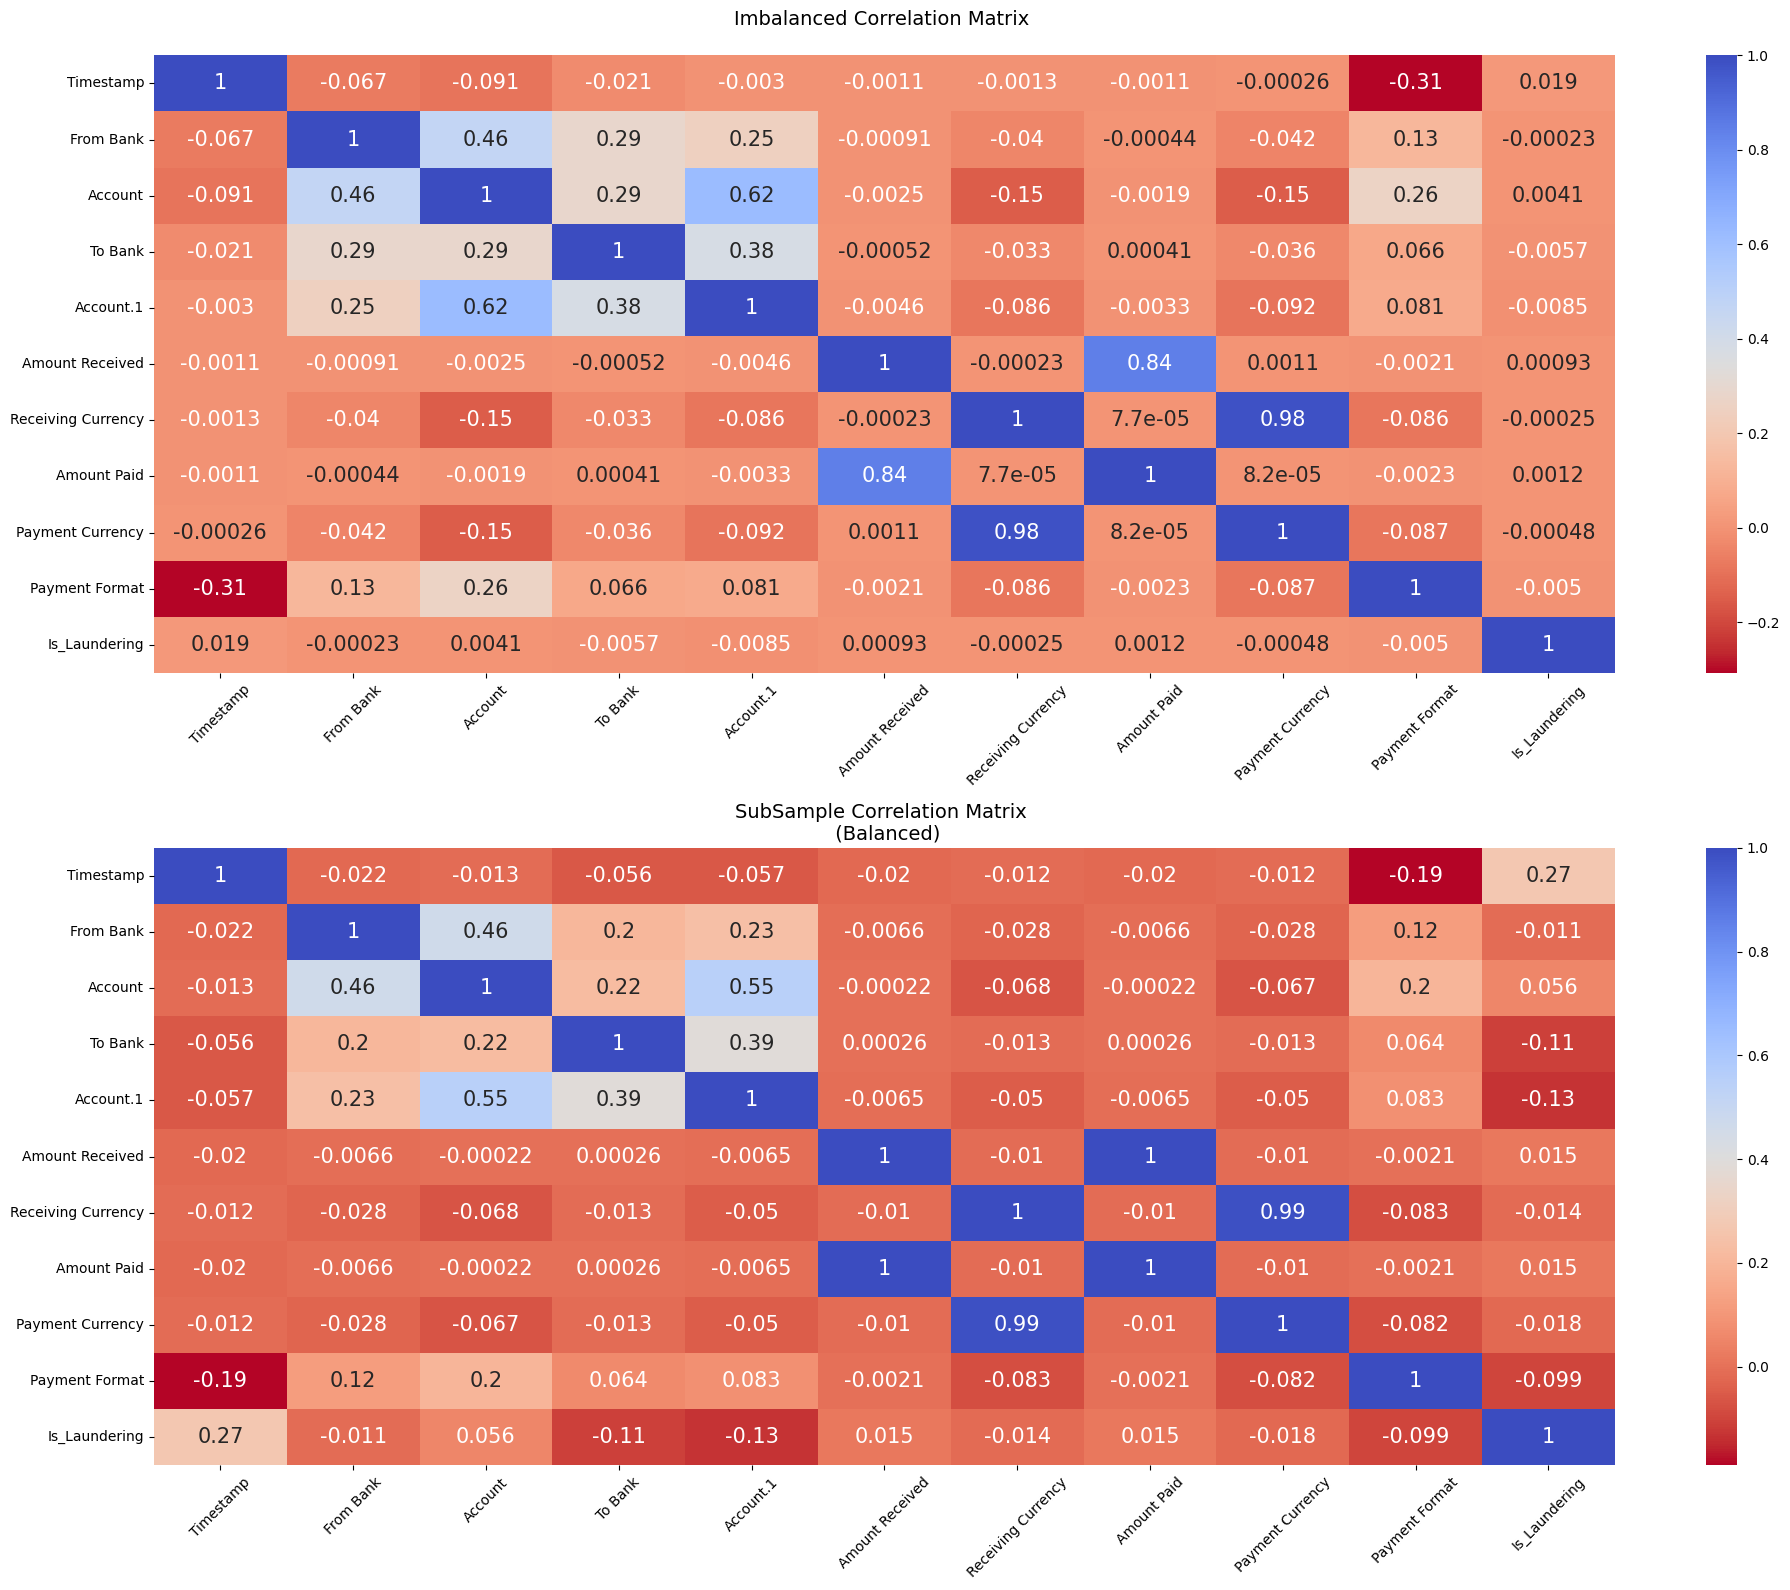

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))

# Entire DataFrame
corr = df_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# 欠采样后的数据集
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()


df_normalized.head()我们发现：
`Timestamp`与labels是正相关的，他的值越大就越可能出现Laundering；`Payment Format`与labels是负相关的，它的值越小就越可能出现Laundering。

**使用箱型图观察上述两个属性的分布：**

/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/1695781758.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/1695781758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])


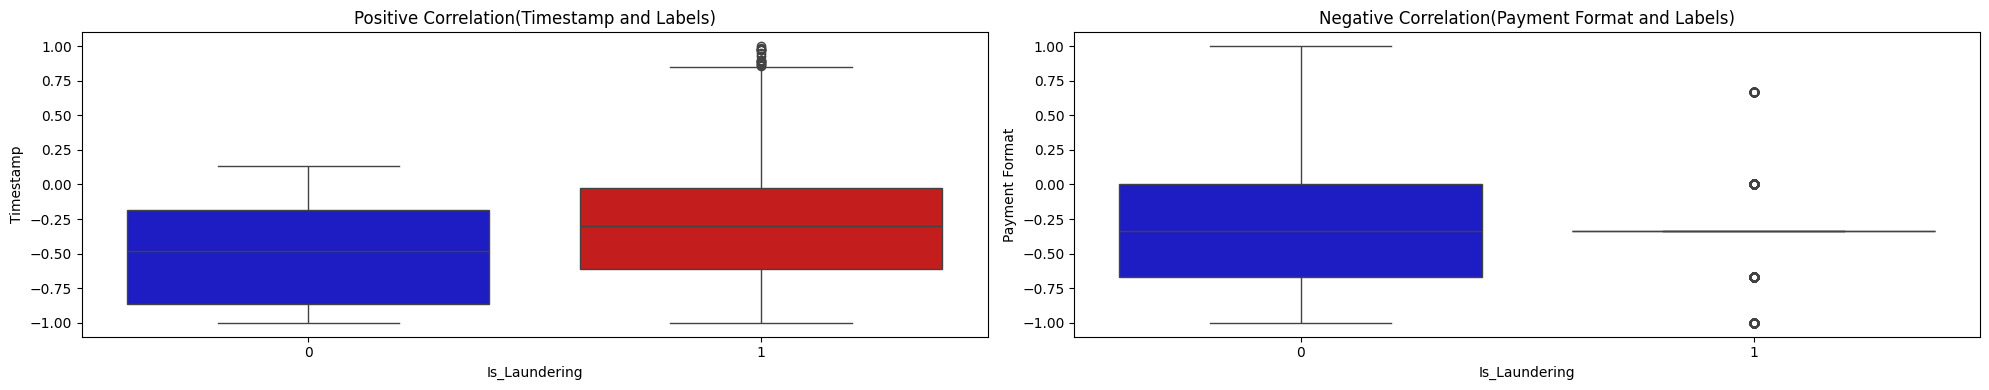

In [25]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')

sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

In [26]:
fig1 = px.scatter(new_df, x="Timestamp", y="Is_Laundering")
fig2 = px.scatter(new_df, x="Payment Format", y="Is_Laundering")
fig1.show()
fig2.show()

在第一个箱型图中，我们可以看到Timestamp列的中位数和四分位数与Is_Laundering列的值呈正相关关系。这意味着，当Is_Laundering列的值为1时，Timestamp列的值通常较大。这可能是因为，洗钱交易通常涉及大量的资金流动，因此需要更长的时间来完成。

在第二个箱型图中，我们可以看到Payment Format列的中位数和四分位数与Is_Laundering列的值关系不大，所以是否洗钱和交易方式并没有直接的关系。

/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/410699131.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




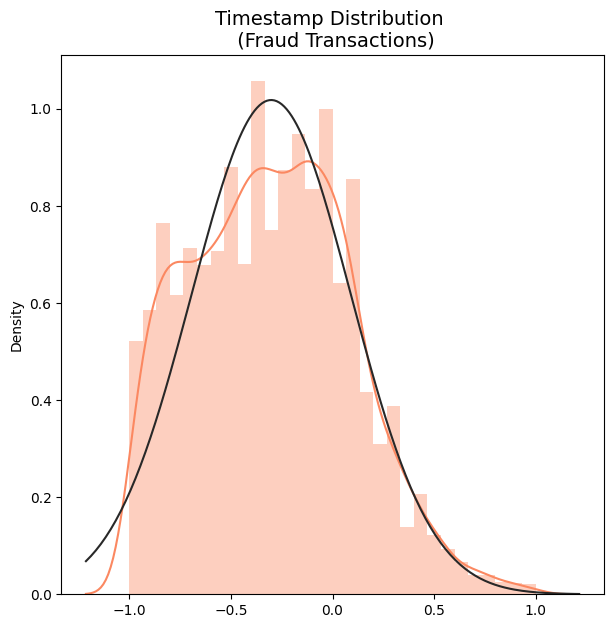

In [27]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

可以看到，timestamp属性的值是比较接近于正态分布的。

**去除timestamp异常值：**

In [28]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.608767381569578 | Quartile 75: -0.023411108492382482
iqr: 0.5853562730771955
Cut Off: 0.8780344096157933
Timestamp Lower: -1.4868017911853713
Timestamp Upper: 0.8546233011234108
Feature Timestamp Outliers for Fraud Cases: 16
Timestamp outliers:[np.float64(0.9699112263338066), np.float64(0.8555267499414185), np.float64(0.8956713017519178), np.float64(0.8765024746644485), np.float64(0.9764317699741696), np.float64(0.9699112263338066), np.float64(0.8669180611204865), np.float64(0.9704611517008743), np.float64(1.0), np.float64(0.9027417707598033), np.float64(0.9842878466497496), np.float64(0.8919789457145271), np.float64(0.9292953099225087), np.float64(0.8860083274416866), np.float64(0.9530992222485111), np.float64(0.8729672401605058)]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
3910925,-0.169220,-0.242356,0.315746,-0.999360,0.303448,-1.0,-0.714286,-1.0,-0.714286,-0.333333,0
4485312,-0.048001,-0.796948,-0.580760,-0.960476,-0.591470,-1.0,0.714286,-1.0,0.714286,-0.666667,0
1746595,-0.507267,-0.353593,-0.058303,-0.983435,-0.843546,-1.0,0.714286,-1.0,0.714286,-0.333333,1
1948601,-0.597298,-0.856678,-0.068274,-0.923922,-0.460801,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
4913079,0.033938,0.429091,0.934406,-0.137199,0.930843,-1.0,-0.857143,-1.0,-0.857143,0.666667,1


/var/folders/kc/80bgr5kj22dbkqmq9vwstwp00000gn/T/ipykernel_1831/1232609887.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0.25, 'Fewer extreme \n outliers')

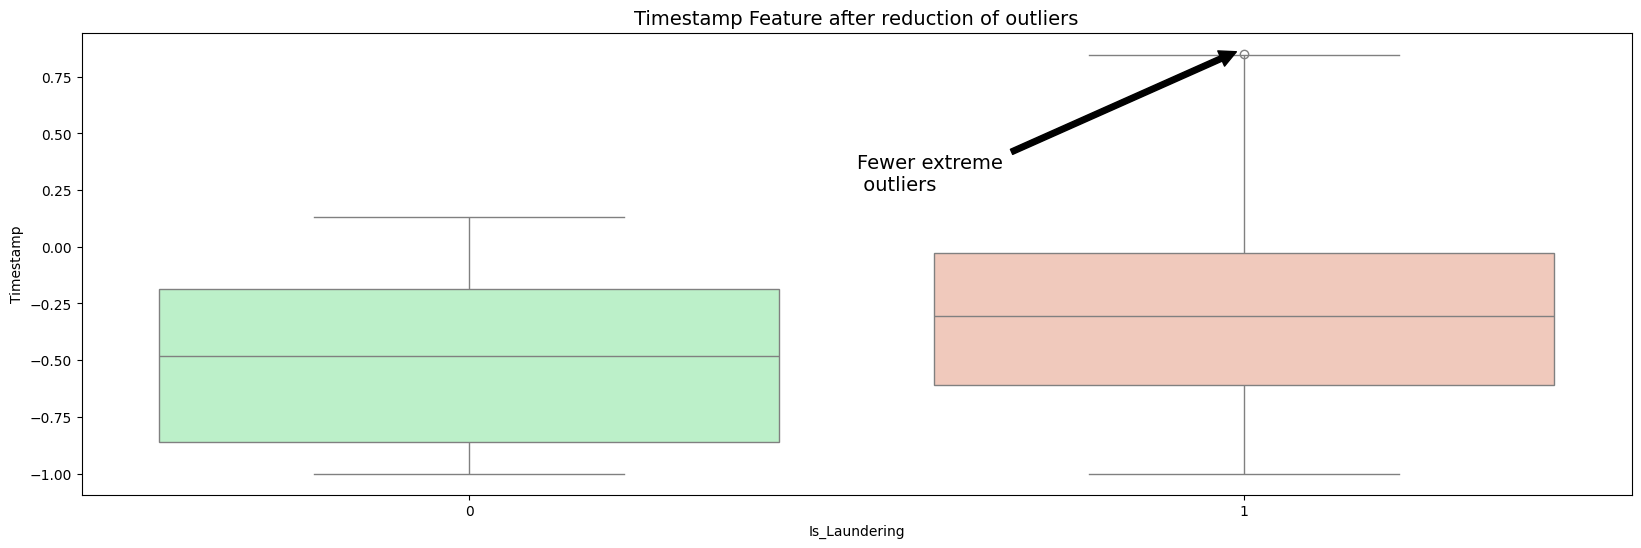

In [29]:
f,ax1 = plt.subplots(figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df,ax=ax1, palette=colors)
ax1.set_title("Timestamp Feature after reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.99, 0.86), xytext=(0.5, 0.25),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

可以看到，当label为1时的timestamp异常值减少了。

**训练模型：**

1. 只采用欠采样后的数据集进行训练。即new_df。

1）new_df数据集直接用来训练

In [30]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def run(data):
    # Undersampling before cross validating (prone to overfit)
    X = data.drop('Is_Laundering', axis=1)
    y = data['Is_Laundering']

    # Our data is already scaled we should split our training and test sets
    from sklearn.model_selection import train_test_split

    # This is explicitly used for undersampling.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Let's implement simple classifiers
    classifiers = {
        "LogisiticRegression": LogisticRegression(),
        "KNearest": KNeighborsClassifier(),
        "Support Vector Classifier": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier()
    }

    # Wow our scores are getting even high scores even when applying cross validation.
    from sklearn.model_selection import cross_val_score

    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
        test_score = classifier.score(X_test, y_test)
        print("Classifiers: ", classifier.__class__.__name__, "Has a test score of", round(test_score, 2) * 100, "% accuracy score\n")


2）降维后的new_df用来训练

a. 使用三种方法分别对new_df进行降维：

In [31]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.7e+01 s
PCA took 0.015 s
Truncated SVD took 0.01 s


b. 使用t-SNE和PCA联合降维

In [32]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_tsne_and_pca = PCA(n_components=2, random_state=42).fit_transform(X_reduced_tsne)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 1.6e+01 s
PCA took 0.0053 s


**可视化降维后的new_df分布情况：**

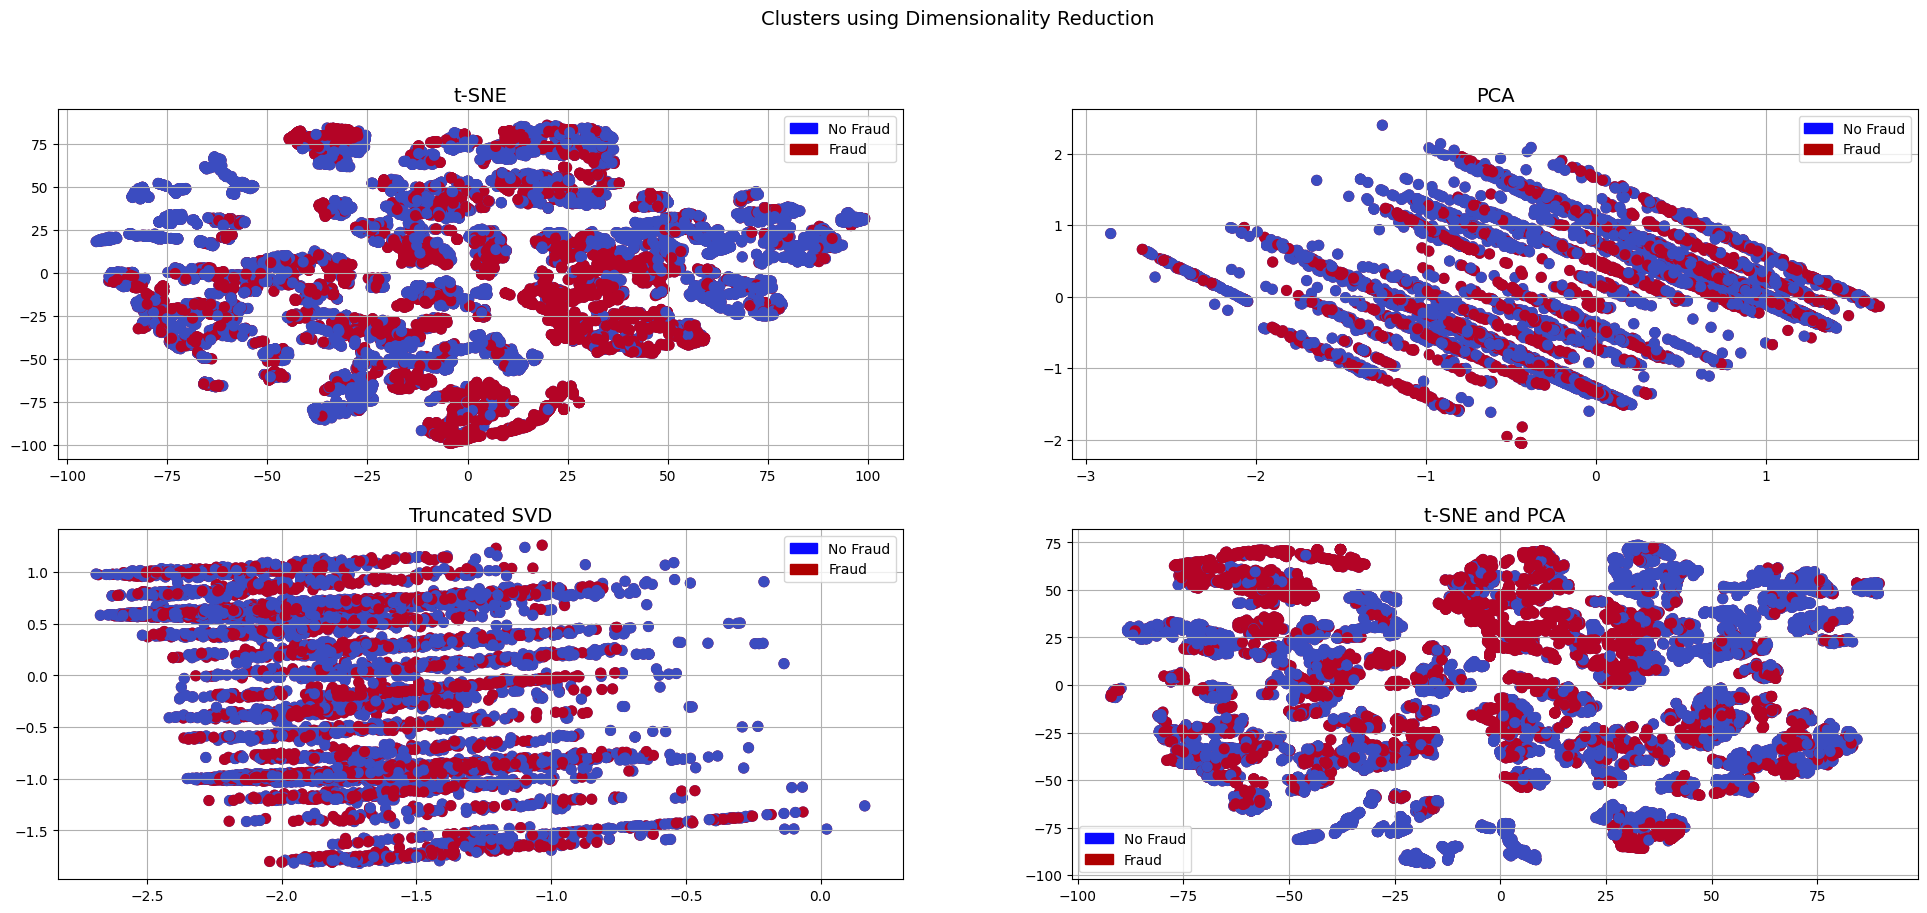

In [33]:
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,10))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

# t-SNE and PCA
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax4.set_title('t-SNE and PCA', fontsize=14)

ax4.grid(True)

ax4.legend(handles=[blue_patch, red_patch])

plt.show()

通过上述降维方法对数据进行可视化后，可以发现数据集中欺诈和非欺诈交易之间的差异不够明显。

**下面进行训练：**

In [34]:
run(new_df)

Classifiers:  LogisticRegression Has a training score of 63.0 % accuracy score
Classifiers:  LogisticRegression Has a test score of 63.0 % accuracy score

Classifiers:  KNeighborsClassifier Has a training score of 82.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a test score of 83.0 % accuracy score

Classifiers:  SVC Has a training score of 82.0 % accuracy score
Classifiers:  SVC Has a test score of 85.0 % accuracy score

Classifiers:  DecisionTreeClassifier Has a training score of 85.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a test score of 86.0 % accuracy score



In [35]:
new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
3910925,-0.169220,-0.242356,0.315746,-0.999360,0.303448,-1.0,-0.714286,-1.0,-0.714286,-0.333333,0
4485312,-0.048001,-0.796948,-0.580760,-0.960476,-0.591470,-1.0,0.714286,-1.0,0.714286,-0.666667,0
1746595,-0.507267,-0.353593,-0.058303,-0.983435,-0.843546,-1.0,0.714286,-1.0,0.714286,-0.333333,1
1948601,-0.597298,-0.856678,-0.068274,-0.923922,-0.460801,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
4913079,0.033938,0.429091,0.934406,-0.137199,0.930843,-1.0,-0.857143,-1.0,-0.857143,0.666667,1


In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# Plot the training loss curve
plt.plot(train_loss, label='train')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'xgboost'